In [21]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.rcParams["figure.figsize"] = (7, 7)


In [22]:
import uproot as ur
events = ur.open(f'test_eicrecon_scale_100GeV_100events.root:events')
#events = ur.open(f'insert_sim_mu-_18GeV_theta_178-178deg.edm4hep.root:events')
arrays_sim = events.arrays()
#print(arrays_sim.fields)
events = ur.open(f'test_eicrecon_scale_100GeV_100events_corr.root:events')
#events = ur.open(f'insert_sim_mu-_18GeV_theta_178-178deg.edm4hep.root:events')
arrays_sim2 = events.arrays()

In [23]:
from scipy.optimize import curve_fit

def gauss(x, A,mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))
#do just the calculation of the resolution
def res_calc(a, fnc=gauss, bins=20, nsigma=2, quantile=None, plot=True, plotArgs={}):
    a=np.array(a)
    mean=np.mean(a)
    sigma=np.std(a)
    if bins is None :
        if quantile==None:
            bins = np.linspace(mean-3*sigma,mean+3*sigma, 20)
        else:
            bins = np.linspace(np.quantile(a, quantile),np.quantile(a, 1-quantile), 20)
    h,x=np.histogram(a, bins=bins)
    bc=(x[1:]+x[:-1])/2
    a_in_window=a[(a>=x[0])&(a<=x[-1])]
    p0=[10,np.mean(a_in_window), np.std(a_in_window)*.9]
    slc=np.abs(bc-np.mean(a_in_window))<nsigma*np.std(a_in_window)
    try:
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        if plot:
            plt.plot(bc, gauss(bc,*coeff), **plotArgs)
        return abs(coeff[2]),np.sqrt(var_matrix[2][2]),coeff[1], np.sqrt(var_matrix[1][1])
    except:
        return 0, 0,0,0

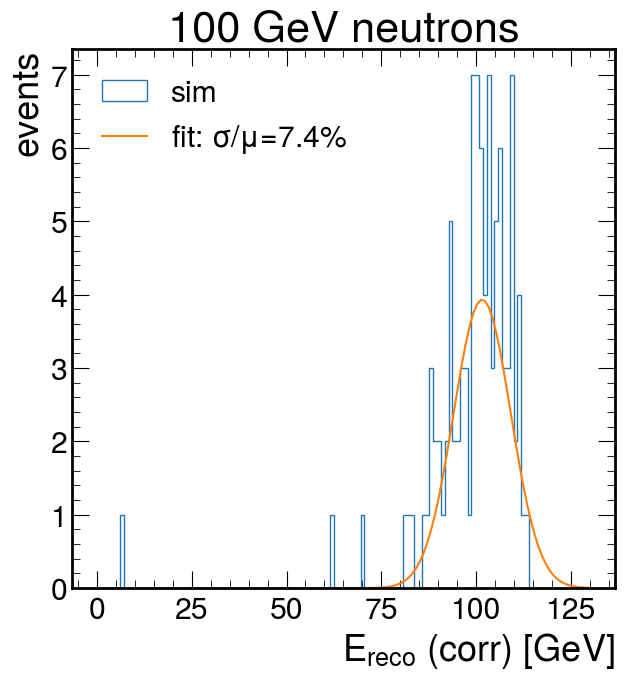

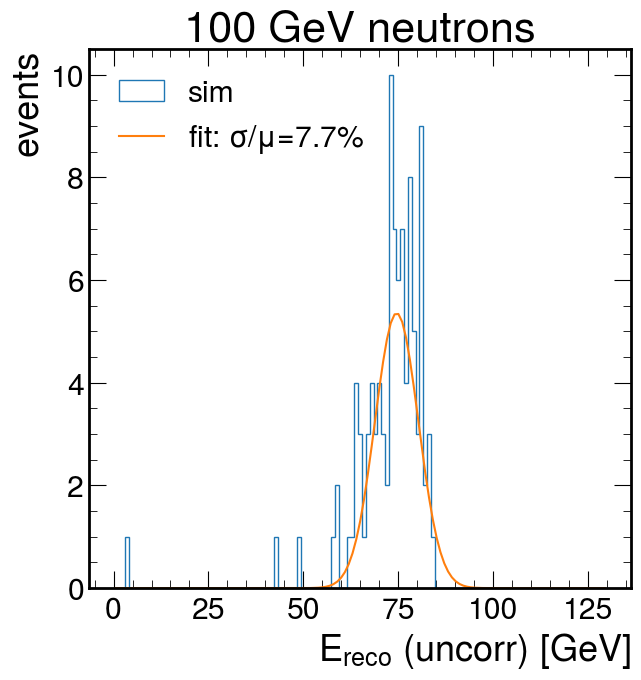

In [24]:
import awkward as ak
#a=ak.flatten(arrays_sim['HcalFarForwardZDCNeutronCandidates.energy'])
#sigma,dsigma, mu, dmu=res_calc(a)
#plt.hist(a, bins=100, histtype='step', label=f'island $\sigma/\mu$={100*sigma/mu:0.1f}%')

for label1 in "corr", "uncorr":
    a=(arrays_sim if label1=="uncorr" else arrays_sim2)['ReconstructedFarForwardZDCNeutrons.energy']
    #sigma,dsigma, mu, dmu=res_calc(a)
    y,x,h=plt.hist(a, bins=np.linspace(0,130,130), histtype='step', label='sim')
    bc=(x[1:]+x[:-1])/2
    p0=[10,75, 5]
    slc=bc>50
    coeff, var_matrix = curve_fit(gauss, bc[slc], y[slc], p0=p0,
                                     sigma=np.sqrt(y[slc]+(y[slc]==0)))
    mu=coeff[1]; sigma=coeff[2]
    label=f'fit: $\sigma/\mu$={100*abs(sigma)/mu:0.1f}%'
    plt.errorbar(bc, gauss(bc,*coeff), label=label)

    plt.xlabel(f"$E_{{reco}}$ ({label1}) [GeV]")
    plt.ylabel("events")
    plt.legend()
    plt.title("100 GeV neutrons")
    plt.show()

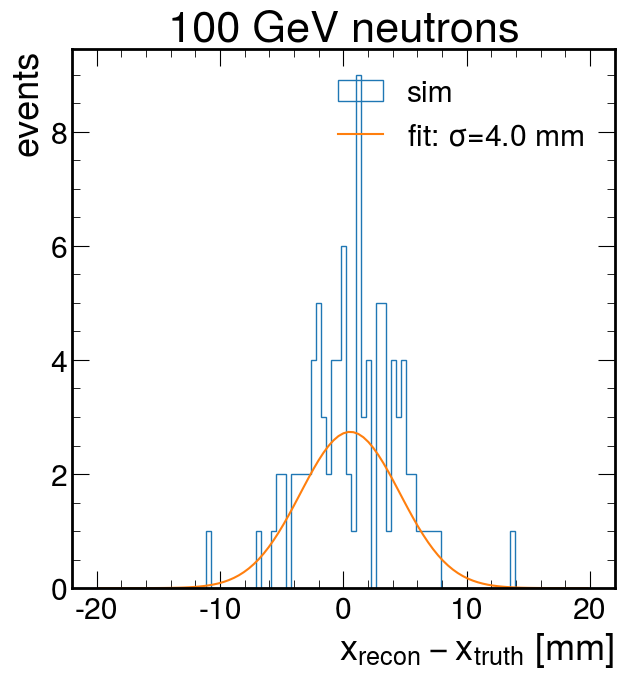

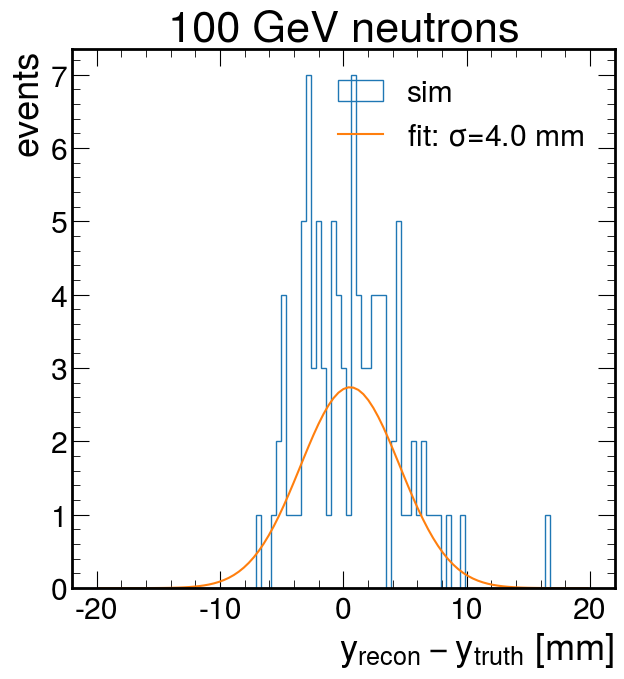

In [28]:
px=arrays_sim2['ReconstructedFarForwardZDCNeutrons.momentum.x']
py=arrays_sim2['ReconstructedFarForwardZDCNeutrons.momentum.y']
pz=arrays_sim2['ReconstructedFarForwardZDCNeutrons.momentum.z']
px_MC=arrays_sim2['MCParticles.momentum.x'][::,2]#[np.sum(px,axis=1)>0 ]
py_MC=arrays_sim2['MCParticles.momentum.y'][::,2]#[np.sum(px,axis=1)>0 ]
pz_MC=arrays_sim2['MCParticles.momentum.z'][::,2]#[np.sum(px,axis=1)>0 ]


z_front_face=35800
a=(px/pz-px_MC/pz_MC)*z_front_face

y,x,_=plt.hist(a, bins=np.linspace(-20,20, 100),label="sim", histtype='step')
bc=(x[1:]+x[:-1])/2
p0=[10,0, 5]
slc=abs(bc<20)
coeff, var_matrix = curve_fit(gauss, bc[slc], y[slc], p0=p0,
                                 sigma=np.sqrt(y[slc]+(y[slc]==0)))
mu=coeff[1]; sigma=coeff[2]
label=f'fit: $\sigma$={sigma:0.1f} mm'
plt.errorbar(bc, gauss(bc,*coeff), label=label)
plt.xlabel("$x_{\\rm recon}-x_{\\rm truth}$ [mm]")
plt.ylabel("events")
plt.title("100 GeV neutrons")
plt.legend()
plt.show()

a=(py/pz-py_MC/pz_MC)*z_front_face
plt.hist(a, bins=np.linspace(-20,20, 100), label='sim', histtype='step')
bc=(x[1:]+x[:-1])/2
p0=[10,0, 5]
slc=abs(bc<20)
coeff, var_matrix = curve_fit(gauss, bc[slc], y[slc], p0=p0,
                                 sigma=np.sqrt(y[slc]+(y[slc]==0)))
mu=coeff[1]; sigma=coeff[2]
label=f'fit: $\sigma$={sigma:0.1f} mm'
plt.errorbar(bc, gauss(bc,*coeff), label=label)
plt.xlabel("$y_{\\rm recon}-y_{\\rm truth}$ [mm]")
plt.ylabel("events")
plt.title("100 GeV neutrons")
plt.legend()
plt.show()

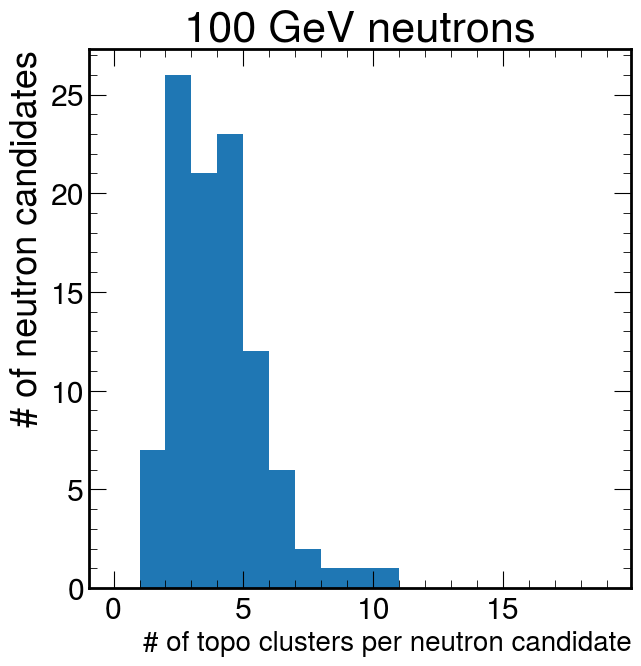

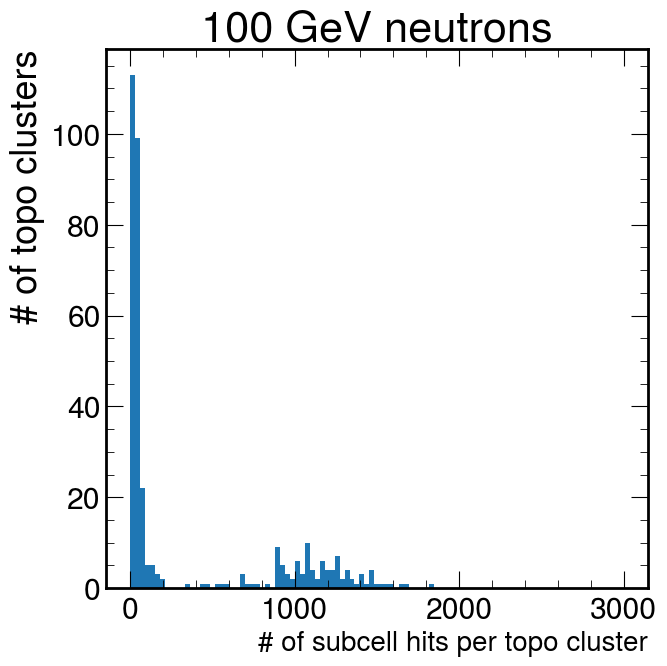

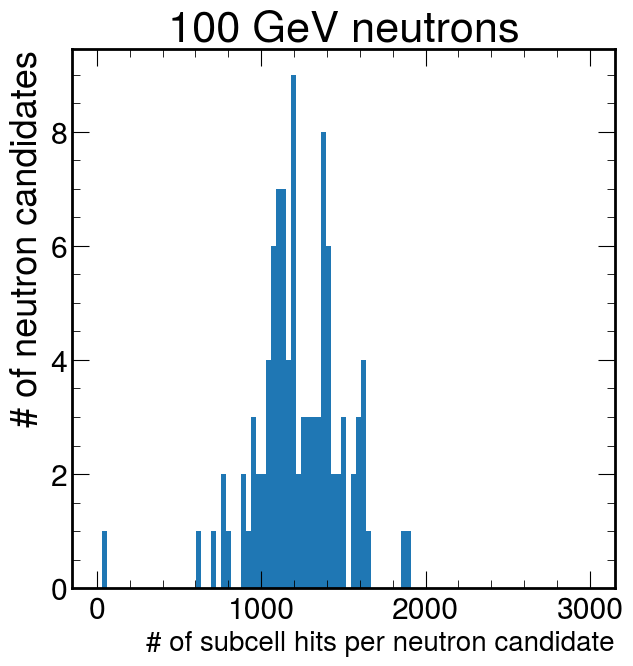

In [31]:
nclusters=arrays_sim2['ReconstructedFarForwardZDCNeutrons.clusters_end']-arrays_sim2['ReconstructedFarForwardZDCNeutrons.clusters_begin']
plt.hist(nclusters, bins=range(20), label ="sim")
plt.xlabel("# of topo clusters per neutron candidate", fontsize=20)
plt.ylabel("# of neutron candidates")
plt.title("100 GeV neutrons")
plt.show()

nhits=ak.flatten(arrays_sim2['HcalFarForwardZDCClusters.nhits'])
plt.hist(nhits, bins=np.linspace(0,3000, 100), label ="sim")
plt.xlabel("# of subcell hits per topo cluster", fontsize=20)
plt.ylabel("# of topo clusters")
plt.title("100 GeV neutrons")
plt.show()

nhits=np.sum(arrays_sim2['HcalFarForwardZDCClusters.nhits'], axis=1)
plt.hist(nhits, bins=np.linspace(0, 3000, 100), label ="sim")
plt.xlabel("# of subcell hits per neutron candidate", fontsize=20)
plt.ylabel("# of neutron candidates")
plt.title("100 GeV neutrons")
plt.show()

Text(0.5, 1.0, '100 GeV neutrons')

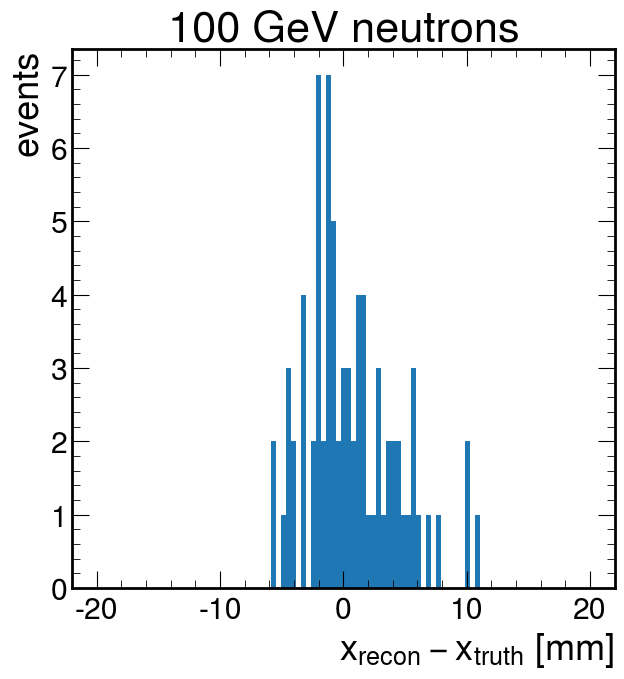

In [16]:
px=np.max(arrays_sim['HcalFarForwardZDCClusters.position.x'], axis=1)
pz=np.max(arrays_sim['HcalFarForwardZDCClusters.position.z'],axis=1)
px_MC=arrays_sim['MCParticles.momentum.x'][::,2]
pz_MC=arrays_sim['MCParticles.momentum.z'][::,2]

plt.hist((px/pz-px_MC/pz_MC)*37500, bins=np.linspace(-20,20, 100))
plt.xlabel("$x_{\\rm recon}-x_{\\rm truth}$ [mm]")
plt.ylabel("events")
plt.title("100 GeV neutrons")

In [38]:
events = ur.open(f'test_eicrecon_100GeV.root:events')
#events = ur.open(f'insert_sim_mu-_18GeV_theta_178-178deg.edm4hep.root:events')
arrays_sim3 = events.arrays()

In [39]:
arrays_sim3.fields

['HcalFarForwardZDCClusters.type',
 'HcalFarForwardZDCClusters.energy',
 'HcalFarForwardZDCClusters.energyError',
 'HcalFarForwardZDCClusters.time',
 'HcalFarForwardZDCClusters.timeError',
 'HcalFarForwardZDCClusters.nhits',
 'HcalFarForwardZDCClusters.position.x',
 'HcalFarForwardZDCClusters.position.y',
 'HcalFarForwardZDCClusters.position.z',
 'HcalFarForwardZDCClusters.positionError.xx',
 'HcalFarForwardZDCClusters.positionError.yy',
 'HcalFarForwardZDCClusters.positionError.zz',
 'HcalFarForwardZDCClusters.positionError.xy',
 'HcalFarForwardZDCClusters.positionError.xz',
 'HcalFarForwardZDCClusters.positionError.yz',
 'HcalFarForwardZDCClusters.intrinsicTheta',
 'HcalFarForwardZDCClusters.intrinsicPhi',
 'HcalFarForwardZDCClusters.intrinsicDirectionError.xx',
 'HcalFarForwardZDCClusters.intrinsicDirectionError.yy',
 'HcalFarForwardZDCClusters.intrinsicDirectionError.xy',
 'HcalFarForwardZDCClusters.shapeParameters_begin',
 'HcalFarForwardZDCClusters.shapeParameters_end',
 'HcalFar

[543, 547, 579, 583, 584, 588, 593, ..., 8934, 8938, 8939, 9243, 9247, 9248]


[77, 81, 82, 86, 88, 89, 90, 91, ..., 7001, 7002, 7003, 7004, 7005, 7006, 7007]


/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_75169/359616780.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sctt3d = ax1.scatter3D(z[i], x[i], y[i],
/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_75169/359616780.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sctt3d = ax1.scatter3D(z_unclustered,


[146, 156, 161, 165, 234, 269, 317, ..., 7411, 7412, 7413, 7414, 7415, 12257]
[84, 85, 95, 144, 145, 147, 148, ..., 10650, 10651, 10652, 10653, 10654, 10655]


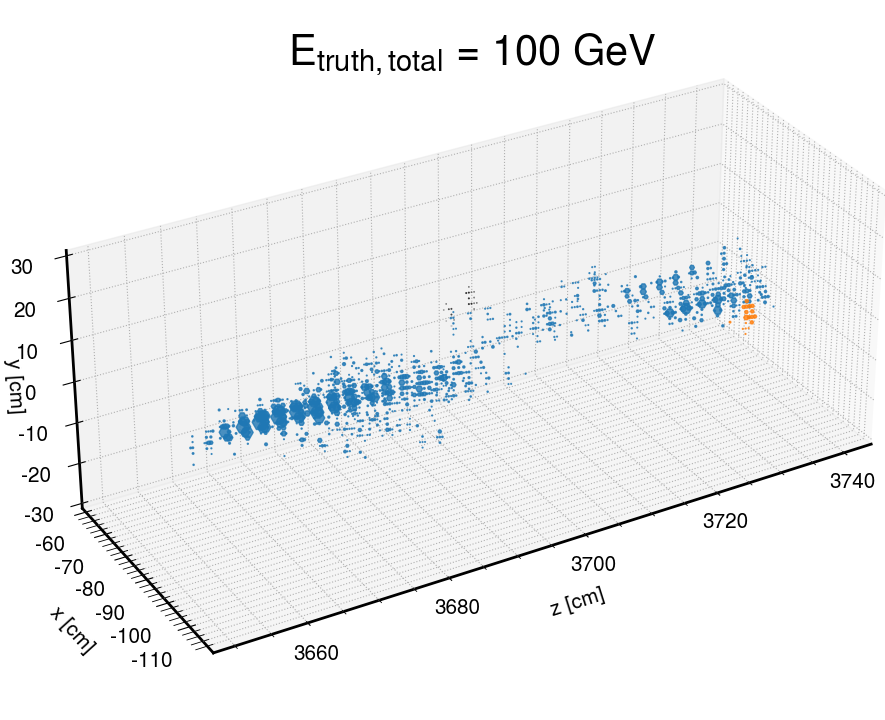

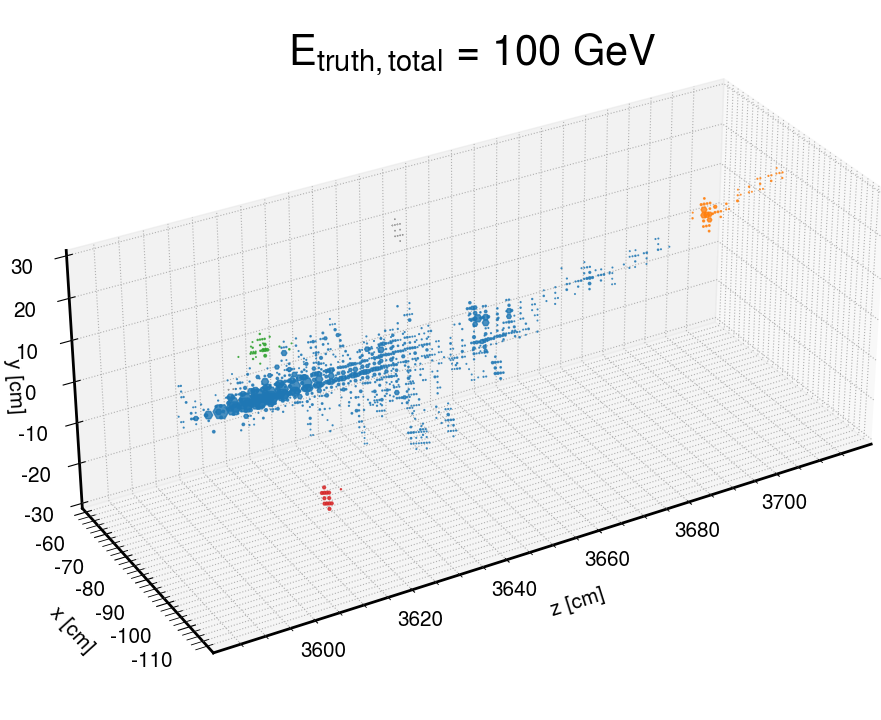

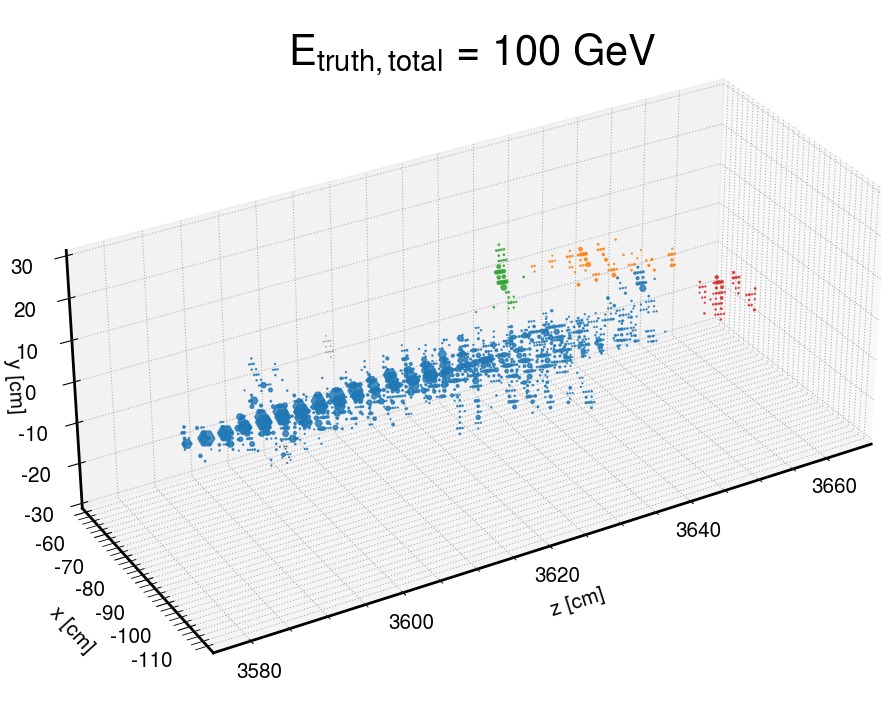

In [80]:
for event in range(3):
    print(arrays_sim3['_HcalFarForwardZDCClusters_hits.index'][event])
    x=[]
    y=[]
    z=[]
    E=[]
    for i in range(len(arrays_sim3['HcalFarForwardZDCClusters.hits_begin'][event])):
        x.append([])
        y.append([])
        z.append([])
        E.append([])
        for j in range(arrays_sim3['HcalFarForwardZDCClusters.hits_begin'][event][i], arrays_sim3['HcalFarForwardZDCClusters.hits_end'][event][i]):
            k = arrays_sim3['_HcalFarForwardZDCClusters_hits.index'][event][j]
            x[i].append(arrays_sim3['HcalFarForwardZDCSubcellHits.position.x'][event][k]/10)
            y[i].append(arrays_sim3['HcalFarForwardZDCSubcellHits.position.y'][event][k]/10)
            z[i].append(arrays_sim3['HcalFarForwardZDCSubcellHits.position.z'][event][k]/10)
            E[i].append(arrays_sim3['HcalFarForwardZDCSubcellHits.energy'][event][k])
        
    x_unclustered=[]
    y_unclustered=[]
    z_unclustered=[]
    E_unclustered=[]
    for i in range(len(arrays_sim3['HcalFarForwardZDCSubcellHits.energy'])):
        if i in arrays_sim3['_HcalFarForwardZDCClusters_hits.index'][event]:
            continue
        x_unclustered.append(arrays_sim3['HcalFarForwardZDCSubcellHits.position.x'][event][i]/10)
        y_unclustered.append(arrays_sim3['HcalFarForwardZDCSubcellHits.position.y'][event][i]/10)
        z_unclustered.append(arrays_sim3['HcalFarForwardZDCSubcellHits.position.z'][event][i]/10)
        E_unclustered.append(arrays_sim3['HcalFarForwardZDCSubcellHits.energy'][event][i])
    
    maxE=max([max(E[i]) for i in range(len(E))])

    fig=plt.figure( figsize=(30,20))
    ax1 = fig.add_subplot(211, projection='3d',azim=-120, elev=30,computed_zorder=False)
    for i in range(len(x)):
        sctt3d = ax1.scatter3D(z[i], x[i], y[i],
                        alpha = 0.8,
                        #color=,
                        s=150*np.array(E[i])/maxE,
                        norm=mpl.colors.LogNorm(),
                        marker ='H')
        
    
    sctt3d = ax1.scatter3D(z_unclustered, 
                           x_unclustered,
                           y_unclustered,
                        alpha = 0.8,
                        color='k',
                        s=150*np.array(E_unclustered)/maxE,
                        norm=mpl.colors.LogNorm(),
                        marker ='H', zorder=-100)
    plt.gca().set_ylim(3580*-.025-30, 3580*-.025+30) #x
    plt.gca().set_zlim(-30, 30) #y    
    #z_ticks = np.arange(-max_val_for_plot, max_val_for_plot+1, max_val_for_plot)
    #y_ticks = np.arange(-max_val_for_plot, max_val_for_plot+1, max_val_for_plot)

    #ax1.set_zticks(z_ticks)
    #ax1.set_yticks(y_ticks)
    #specific_values = np.array([z_min, z_max])
    #x_ticks = np.arange(z_min, z_max, 40)

    # Concatenate the specific values with the generated array
    #x_ticks = np.append(x_ticks, [z_max])
    #ax1.set_xticks(x_ticks)

    plt.gca().zaxis.labelpad = -2
    ax1.set_title(f"$E_{{truth,total}}$ = {100} GeV", fontsize=30, pad=-40)
    plt.gca().set_xlabel("\n\nz [cm]", fontsize=15)
    plt.gca().set_ylabel("\nx [cm]", fontsize=15)
    plt.gca().set_zlabel("y [cm]", fontsize=15)
    #plt.gca().set_xlim(z_min, z_max)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().zaxis.set_tick_params(labelsize=15)

    plt.gca().set_box_aspect((180,70,70), zoom=1.2)



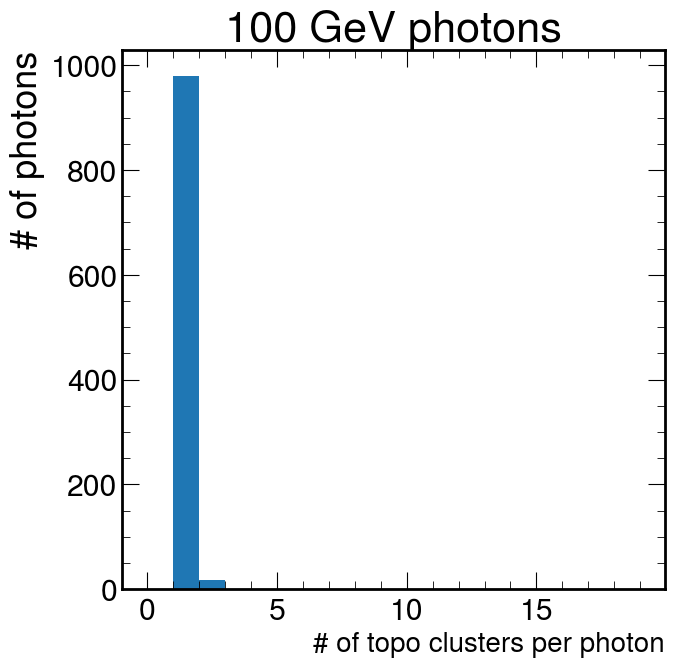

In [82]:
arrays_sim4=ur.open(f'test_eicrecon_gamma_100GeV.root:events').arrays()

nclusters=arrays_sim4['ReconstructedFarForwardZDCNeutrons.clusters_end']-arrays_sim4['ReconstructedFarForwardZDCNeutrons.clusters_begin']
plt.hist(nclusters, bins=range(20), label ="sim")
plt.xlabel("# of topo clusters per photon", fontsize=20)
plt.ylabel("# of photons")
plt.title("100 GeV photons")
plt.show()


Text(0.5, 1.0, '100 GeV Photons')

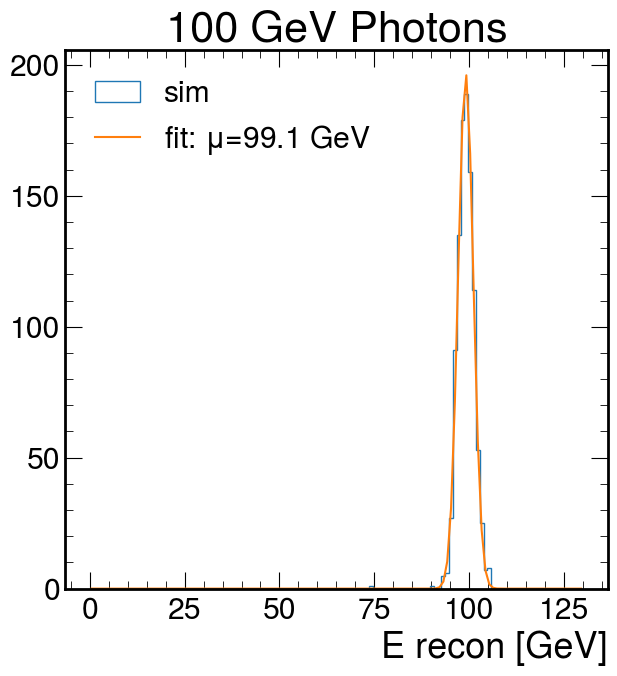

In [97]:
a=np.sum(arrays_sim4['HcalFarForwardZDCClusters.energy'], axis=-1)
#sigma,dsigma, mu, dmu=res_calc(a)
y,x,h=plt.hist(a, bins=np.linspace(0,130,130), histtype='step', label='sim')
bc=(x[1:]+x[:-1])/2
p0=[10,100, 5]
slc=bc>50
coeff, var_matrix = curve_fit(gauss, bc[slc], y[slc], p0=p0,
                                 sigma=np.sqrt(y[slc]+(y[slc]==0)))
mu=coeff[1]; sigma=coeff[2]
label=f'fit: $\mu$={mu:.1f} GeV'
plt.errorbar(bc, gauss(bc,*coeff), label=label)
plt.xlabel("E recon [GeV]")
plt.legend()
plt.title("100 GeV Photons")